In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
df = pd.read_parquet("data/processed_data.parquet")   

In [3]:
dt_columns = df.columns[df.columns.str.startswith("DT_")].to_list()

In [4]:
cd_columns = df.columns[df.columns.str.startswith("CD_")].to_list()

In [5]:
gn_columns = df.columns[df.columns.str.startswith("GN_")].to_list()

In [6]:
fl_columns = df.columns[df.columns.str.startswith("FL_")].to_list()

In [7]:
excluded_columns = set(dt_columns) | set(cd_columns) | set(gn_columns) | set(fl_columns) 
other_columns = [col for col in df.columns if col not in excluded_columns]

In [8]:
columns_keep = [
 "DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE",
 "DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE",
 'CD_DATA_OWNER_LOGICAL_REGION_CODE',
 'CD_COMMERCIAL_ORDER_CODE',
 'CD_BRAND_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_ORIGINAL_CODE',
 'CD_VEHICLE_CAR_LINE_CODE',
 'CD_MODEL_CODE',
 'CD_VEHICLE_PRODUCT_LINE_CODE',
 'CD_VEHICLE_COMMERCIAL_FAMILY_ORIGIN_CODE',
 'CD_VEHICLE_VERSION_CODE',
 'CD_REGION_CODE',
 'CD_SALES_REGION_CODE',
 'CD_MARKET_CODE',
 'CD_PROGRAMMING_MARKET_CODE',
 'CD_PLANT_LOGISTIC_CODE',
 'CD_FINAL_CUSTOMER_ORDER_CODE',
 'CD_VEHICLE_ORDER_ORIGIN_CODE',
 'CD_COMMERCIAL_ORDER_STATUS_CODE',
 'GN_BRAND_ORIGINAL_NAME',
 'GN_VEHICLE_COMPLETE_DESCRIPTION_NAME',
 'GN_VEHICLE_CAR_LINE_NAME',
 'GN_CUSTOMER_SALES_CHANNEL_NAME',
 "FL_IS_ORDER_ACTIVE_FLAG",
 "FL_IS_VEHICLE_FOR_SHOWROOM_FLAG",
 "FL_IS_VEHICLE_FOR_DEMOSTRATION_FLAG",
 "FL_IS_FINAL_CUSTOMER_ORDER_ISSUED_FLAG",
 "FL_IS_ONLINE_SALES_FLAG",
 "FL_IS_DIRECT_SALES_FLAG",
 "CD_SHIPPING_ZONE_CODE",
 'IS_INTERNATIONAL', 
 'is_missing_CD_FINAL_CUSTOMER_ORDER_CODE',
 'is_missing_CD_VEHICLE_ORDER_ORIGIN_CODE',
 'Is_Delayed',
 'REG_Delay_Days',
 'Destination_Type'
    ]

In [9]:
# Selected features
df_filtred = df[columns_keep].copy()

In [10]:
df_filtred["GN_CUSTOMER_SALES_CHANNEL_NAME"].fillna(df_filtred["GN_CUSTOMER_SALES_CHANNEL_NAME"].mode()[0], inplace=True)

In [11]:
cat_cols = ['CD_DATA_OWNER_LOGICAL_REGION_CODE',
 'CD_COMMERCIAL_ORDER_CODE',
 'CD_BRAND_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_CODE',
 'CD_VEHICLE_TYPE_HOMOLOGATION_ORIGINAL_CODE',
 'CD_VEHICLE_CAR_LINE_CODE',
 'CD_MODEL_CODE',
 'CD_VEHICLE_PRODUCT_LINE_CODE',
 'CD_VEHICLE_COMMERCIAL_FAMILY_ORIGIN_CODE',
 'CD_VEHICLE_VERSION_CODE',
 'CD_REGION_CODE',
 'CD_SALES_REGION_CODE',
 'CD_MARKET_CODE',
 'CD_PROGRAMMING_MARKET_CODE',
 'CD_PLANT_LOGISTIC_CODE',
 'CD_FINAL_CUSTOMER_ORDER_CODE',
 'CD_VEHICLE_ORDER_ORIGIN_CODE',
 'CD_COMMERCIAL_ORDER_STATUS_CODE',
 'GN_BRAND_ORIGINAL_NAME',
 'GN_VEHICLE_COMPLETE_DESCRIPTION_NAME',
 'GN_VEHICLE_CAR_LINE_NAME',
 'GN_CUSTOMER_SALES_CHANNEL_NAME',
 "CD_SHIPPING_ZONE_CODE",
 "Destination_Type"]

In [12]:
for col in cat_cols:
    df_filtred[col] = df_filtred[col].astype('category')

In [13]:
df_filtred['ORDER_CREATION_MONTH'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.month
df_filtred['ORDER_CREATION_WEEKDAY'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.weekday
df_filtred['ORDER_CREATION_YEAR'] = pd.to_datetime(df_filtred['DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE']).dt.year

In [14]:
df_filtred['ORDER_EXPECTED_MONTH'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.month
df_filtred['ORDER_EXPECTED_WEEKDAY'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.weekday
df_filtred['ORDER_EXPECTED_YEAR'] = pd.to_datetime(df_filtred['DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE']).dt.year

In [15]:
df_filtred.drop(columns=["DT_COMMERCIAL_ORDER_FIRST_ENTRY_DATE","DT_EXPECTED_DELIVERY_TO_FINAL_CUSTOMER_DATE"],inplace=True)

In [16]:
exclude = ['REG_Delay_Days', 'Is_Delayed']
X = df_filtred[[col for col in df_filtred.columns if col not in exclude]]
y_class = df_filtred['Is_Delayed']
y_reg = df_filtred['REG_Delay_Days']

In [17]:
X_train, X_test, y_class_train, y_class_test, y_reg_train, y_reg_test = train_test_split(
    X, y_class, y_reg, test_size=0.2, stratify=y_class, random_state=42
)

In [18]:
cat_cols = [col for col in X.columns if str(df_filtred[col].dtype) == 'category']

clf = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=100
)
clf.fit(
    X_train, y_class_train,
    eval_set=[(X_test, y_class_test)],
    categorical_feature=cat_cols,
    early_stopping_rounds=10,
    verbose=10
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/sagemaker-distribution/lib/pyth

[10]	valid_0's binary_logloss: 0.608451
[20]	valid_0's binary_logloss: 0.571632
[30]	valid_0's binary_logloss: 0.555245
[40]	valid_0's binary_logloss: 0.545805
[50]	valid_0's binary_logloss: 0.540483
[60]	valid_0's binary_logloss: 0.539076
[70]	valid_0's binary_logloss: 0.538642
[80]	valid_0's binary_logloss: 0.536889
[90]	valid_0's binary_logloss: 0.537231


LGBMClassifier(learning_rate=0.05, objective='binary')

In [19]:
reg = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=100
)
reg.fit(
    X_train, y_reg_train,
    eval_set=[(X_test, y_reg_test)],
    categorical_feature=cat_cols,
    early_stopping_rounds=10,
    verbose=10
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/envs/sagemaker-distribution/lib/pyth

[10]	valid_0's l2: 2421.94
[20]	valid_0's l2: 2106.63
[30]	valid_0's l2: 1970.66
[40]	valid_0's l2: 1911.21
[50]	valid_0's l2: 1882.27
[60]	valid_0's l2: 1882.49


LGBMRegressor(learning_rate=0.05, objective='regression')

In [20]:
from sklearn.metrics import classification_report, roc_auc_score

y_class_pred = clf.predict(X_test)
print(classification_report(y_class_test, y_class_pred))
print("ROC-AUC:", roc_auc_score(y_class_test, y_class_pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74       973
           1       0.74      0.67      0.70       921

    accuracy                           0.72      1894
   macro avg       0.72      0.72      0.72      1894
weighted avg       0.72      0.72      0.72      1894

ROC-AUC: 0.7208818333885706


In [21]:

y_reg_pred = reg.predict(X_test)
print("MAE:", mean_absolute_error(y_reg_test, y_reg_pred))
print("RMSE:", mean_squared_error(y_reg_test, y_reg_pred, squared=False))

MAE: 24.12738722236983
RMSE: 43.38509503376037


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


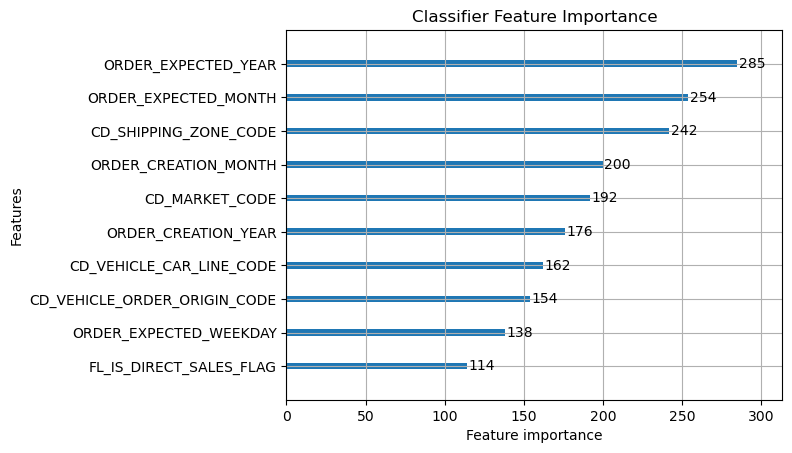

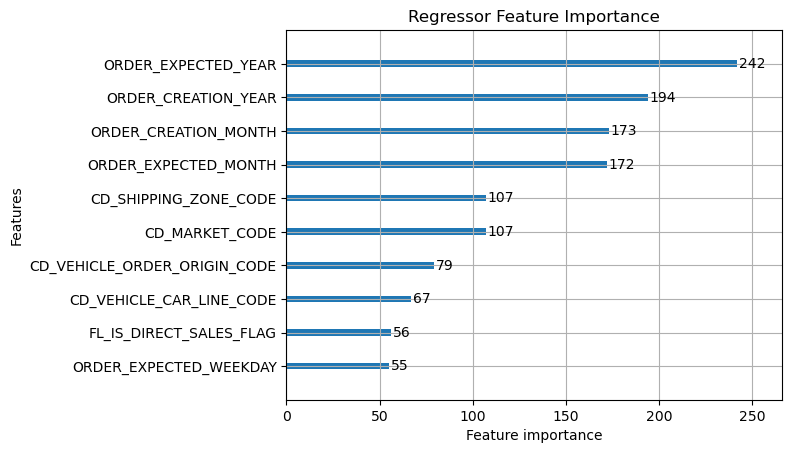

In [22]:
lgb.plot_importance(clf, max_num_features=10, title="Classifier Feature Importance")
plt.show()

lgb.plot_importance(reg, max_num_features=10, title="Regressor Feature Importance")
plt.show()